In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import date, timedelta

from sqlalchemy import create_engine
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import func, distinct
from sqlalchemy import or_

In [2]:
# Vacation range is 10/01 to 10/10

In [3]:
# Connect to sqlite database
engine = create_engine('sqlite:///hawaii.sqlite')

In [4]:
# Set up session
session = Session(engine)

In [5]:
# Reflect tables into classes
Base = automap_base()
Base.prepare(engine, reflect=True)

In [6]:
# Save references to tables
Measurements = Base.classes.measurements
Stations = Base.classes.stations

In [7]:
Base.classes.keys()

['measurements', 'stations']

### Precipitation Analysis

In [8]:
# Retrieve the last 12 months
# Inspecting the data, the last date was 2017-08-23
last_12_mths = session.query(Measurements.date, Measurements.prcp)\
.filter(or_(Measurements.date.like('2017-%'), # all records from 2017
            Measurements.date.like('2016-1%'), # from oct to dec of 2016
            Measurements.date.like('2016-09%'), # from sep 2016
            Measurements.date.like('2016-08-3%'), # from aug 30 and 31 2016
            Measurements.date.like('2016-08-24'), # the rest added manually
            Measurements.date.like('2016-08-25'),
            Measurements.date.like('2016-08-26'),
            Measurements.date.like('2016-08-27'),
            Measurements.date.like('2016-08-28'),
            Measurements.date.like('2016-08-29'))
       )

In [9]:
# Load just the date and precipitation into a DataFrame
prcp_12mths_df = pd.read_sql_query(last_12_mths.statement.compile(engine), con=engine)

# Due to multiple recordings per date, take the mean of each date
prcp_by_date_df = pd.DataFrame(prcp_12mths_df.groupby('date').mean())

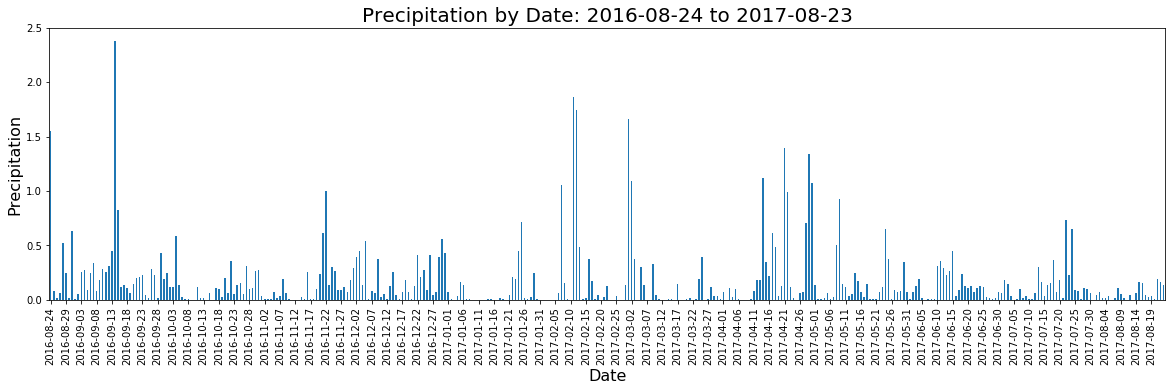

In [10]:
# Plot precipitation by date
ax = prcp_by_date_df.prcp.plot(kind='bar', figsize=(20, 5))

plt.title('Precipitation by Date: %s to %s' \
          %(prcp_by_date_df.index[0], prcp_by_date_df.index[-1]), fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Precipitation', fontsize=16)

# Reduce number of xticks to make it look nicer
ax.set_xticklabels(prcp_by_date_df.index[0::5])
plt.locator_params(axis='x', nbins=73)

plt.show()

In [11]:
print(prcp_by_date_df.describe())

             prcp
count  365.000000
mean     0.169987
std      0.295722
min      0.000000
25%      0.008571
50%      0.070000
75%      0.191667
max      2.380000


### Station Analysis

In [12]:
# Count number of unique stations
print(session.query(func.count(distinct(Stations.station)))[0][0])

9


In [13]:
# Join stations and measurements tables 
# Group by station, order by number of observations
stations_fill_active = session.query(Stations.station, func.count(Measurements.station))\
.join(Measurements, Stations.station==Measurements.station)\
.group_by(Stations.station).order_by(func.count(Measurements.tobs).desc())

In [14]:
# Show stations, most active on top
for each in stations_fill_active.all():
    print(f'Station: {each[0]} | Observations: {each[1]}')

Station: USC00519281 | Observations: 2772
Station: USC00513117 | Observations: 2696
Station: USC00519397 | Observations: 2685
Station: USC00519523 | Observations: 2572
Station: USC00516128 | Observations: 2484
Station: USC00514830 | Observations: 1937
Station: USC00511918 | Observations: 1932
Station: USC00517948 | Observations: 683
Station: USC00518838 | Observations: 342


In [15]:
# Print the most active station
print(
    f'Most active station: {stations_fill_active.all()[0][0]}\
    \nNumber of Observations: {stations_fill_active.all()[0][1]}'
)

Most active station: USC00519281    
Number of Observations: 2772


In [16]:
# Retrieve data from the last 12 months from the most active station
most_active_last_12m_tobs = session.query(Measurements.tobs)\
.filter(or_(Measurements.date.like('2017-%'), # all records from 2017
            Measurements.date.like('2016-1%'), # from oct to dec of 2016
            Measurements.date.like('2016-09%'), # from sep 2016
            Measurements.date.like('2016-08-3%'), # from aug 30 and 31 2016
            Measurements.date.like('2016-08-24'), # the rest added manually
            Measurements.date.like('2016-08-25'),
            Measurements.date.like('2016-08-26'),
            Measurements.date.like('2016-08-27'),
            Measurements.date.like('2016-08-28'),
            Measurements.date.like('2016-08-29'))
       ).filter(Measurements.station==str(stations_fill_active.all()[0][0]))

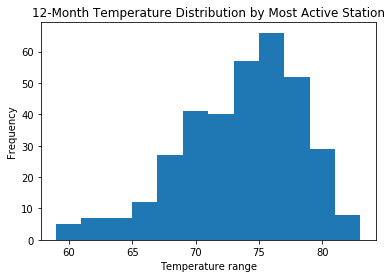

In [17]:
# Convert the results to a list of all the temperature readings
most_active_temp_list = [each[0] for each in most_active_last_12m_tobs]

# Plot the results as histogram
plt.hist(most_active_temp_list, bins=12)

plt.title('12-Month Temperature Distribution by Most Active Station')
plt.xlabel('Temperature range')
plt.ylabel('Frequency')

plt.show()

### Temperature Analysis

In [18]:
# Step 1: parse date strings to date object
def parse_date(date_string):
    try:
        date_parts = date_string.split('-')

        year = int(date_parts[0])
        month = int(date_parts[1])
        day = int(date_parts[2])

        date_object = date(year, month, day)
        return date_object
    except:
        print('Error: Check date string format')

In [19]:
# Step 2: get all the dates between the starting and ending dates
def get_dates_between(start_date_obj, end_date_obj):
    
    date_obj_list = []
    delta = end_date_obj - start_date_obj
    
    for i in range(delta.days+1):
        new_date = start_date_obj + timedelta(days=i)
        date_obj_list.append(new_date)
        
    return date_obj_list

In [20]:
# Step 3: reformat the in-between dates to string
def convert_dates_list(date_obj_list):
    date_str_list = [date.strftime(each, '%Y-%m-%d')\
                         for each in date_obj_list]
    return date_str_list

In [21]:
# Step 4: query data from the target dates
def query_temps(date_str_list):
    temp_stats_query = session.query(Measurements.date, 
                               func.min(Measurements.tobs), 
                               func.avg(Measurements.tobs),
                               func.max(Measurements.tobs))\
    .filter(Measurements.date.in_(date_str_list)).group_by(Measurements.date)
    
    return temp_stats_query

In [22]:
# Step 5: use the query results to make a DataFrame
def make_temp_df(temp_stats_query):
    
    temp_stats_all_list = [list(each) for each in temp_stats_query.all()]
    temp_stats_df = pd.DataFrame(temp_stats_all_list, columns=['date', 'low', 'avg', 'high'])
    
    return temp_stats_df

In [23]:
# Putting it all together
def calc_temps(start_date_str, end_date_str):
    
    start_date_obj = parse_date(start_date_str)
    end_date_obj = parse_date(end_date_str)
    
    date_obj_list = get_dates_between(start_date_obj, end_date_obj)
    
    date_str_list = convert_dates_list(date_obj_list)
    
    temp_stats_query = query_temps(date_str_list)
    
    temp_stats_df = make_temp_df(temp_stats_query)
    
    return temp_stats_df

In [24]:
# Create the DataFrame of temperatures for our dates
temp_stats_df = calc_temps('2016-10-01', '2016-10-10')

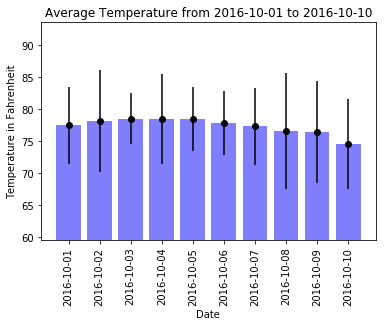

In [25]:
# Plot the temperatures
# Set up x-axis & errorbars
x_positions = range(0, len(temp_stats_df))
x_labels = list(temp_stats_df.date)
yerr=[h - l for h, l in zip(temp_stats_df.high, temp_stats_df.low)]

# Plots
plt.bar(x_positions, temp_stats_df.avg, alpha=0.5, color='blue')
plt.errorbar(x_positions, temp_stats_df.avg, yerr=yerr, color='black', fmt='o')

# Labels
plt.xticks(x_positions, x_labels, rotation=90)
plt.xlabel('Date')
plt.ylabel('Temperature in Fahrenheit')
plt.title(f'Average Temperature from {x_labels[0]} to {x_labels[-1]}')

# Pretty it up
plt.ylim(temp_stats_df.avg.min() - 15, temp_stats_df.avg.max() + 15)

plt.show()